In [667]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from tqdm import tqdm

Read the clock image and threshold it

(-0.5, 1279.5, 1279.5, -0.5)

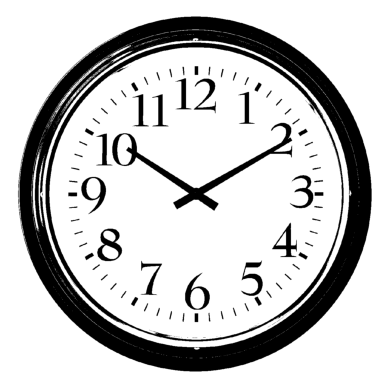

In [668]:
clock = cv2.imread("clock.jpg")
clock = cv2.cvtColor(clock, cv2.COLOR_BGR2GRAY)
_, clock = cv2.threshold(clock, 127, 255, cv2.THRESH_BINARY)
plt.imshow(clock, cmap="gray")

plt.axis("off")

In [669]:
def generate_clock(h, m) -> BytesIO:
    """
    Generates a clockface for a given hour and minute.
    """
    h_r = 0.4
    m_r = 0.6

    h_ang = (np.pi / 2 + (-h / 12) * 2 * np.pi - ((2 * np.pi) / 12) * (m/60))
    m_ang = (np.pi / 2 + (-m / 60) * 2 * np.pi)

    h_x = h_r * np.cos(h_ang)
    h_y = h_r * np.sin(h_ang)

    m_x = m_r * np.cos(m_ang)
    m_y = m_r * np.sin(m_ang)

    plt.clf()

    plt.plot([0, h_x], [0, h_y], "black", linewidth=3)
    plt.plot([0, m_x], [0, m_y], "black", linewidth=3)

    plt.axis("square")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis("off")

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', pad_inches=0)
    plt.close()

    def buf2img(buf):
        buf.seek(0)
        img = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
        return img
    
    img = buf2img(buf)
    return img

Generate all possible clockfaces

In [670]:
generated_clocks = []
with tqdm(total=12*60) as pbar:
    for h in range(0, 12):
        for m in range(0, 60):
            generated_clock = generate_clock(h, m)
            generated_clocks.append(generated_clock)

            pbar.update(1)
            

100%|██████████| 720/720 [00:15<00:00, 47.36it/s]


See which generated clockface has the most overlap with the actual clock

0it [00:00, ?it/s]

720it [00:00, 12800.68it/s]

best guess: 610 10 10


(-0.5, 368.5, 368.5, -0.5)

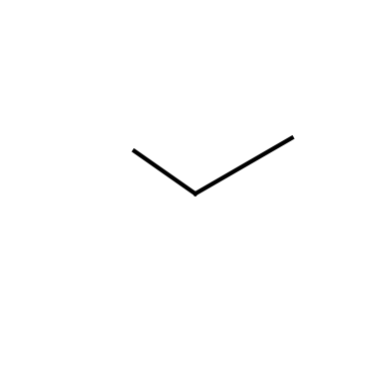

In [671]:
# idx err
best_guess = (None, 0)

generated_clock = generate_clock(0, 0)

width, height = generated_clock.shape

clock = cv2.resize(clock, (width, height))

for index, generated_clock in tqdm(enumerate(generated_clocks)):
    if index == 0:
        continue

    # get guess where most black pixels overlap
    overlap = cv2.bitwise_and(clock, generated_clock)
    ones = np.count_nonzero(overlap)

    if ones > best_guess[1]:
        best_guess = (index, ones)

best_index = best_guess[0]
h = best_guess[0] // 60
m = best_guess[0] % 60
print("best guess:", best_index, h, m)

plt.imshow(generated_clocks[best_index], cmap="gray")
plt.axis("off")